In this example we reduce the data for a delay scan using the time tool, stack two runs, load the stacked data, separate the isotropic and anisotropic components, and plot them. 

# inputs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio
from scipy.optimize import curve_fit


from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *
from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *
from LCLSDataToolsNew.IRFtools import *
from LCLSDataToolsNew.plottingTools import *

print('Import Complete!')

exper = 'xcsly5320'
### ffb ###
# smalldata_folder='/cds/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### call ffb from psana ###
# smalldata_folder='/reg/data/drpsrcf/xcs/'+exper+'/scratch/hdf5/smalldata/'
### psana ###
smalldata_folder='/reg/d/psdm/xcs/'+exper+'/hdf5/smalldata/smdBeamtime/'


# outpath='/reg/d/psdm/xcs/'+exper+'/results/ReducedData/'
# outpath='/reg/d/psdm/xcs/'+exper+'/scratch/slr/'
outpath='/cds/home/s/slraj/code/ScatteringCode/'

# #make directories if needed 
if os.path.isdir(outpath+'/figures/')==False:
    os.makedirs(outpath+'/figures/')
if os.path.isdir(outpath+'/npy/')==False:
    os.makedirs(outpath+'/npy/')


Import Complete!


## set up varDict

In [2]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 

        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',


        }

## set up paramDict

In [15]:
setbins=np.arange(-0.4e-12,1.3e-12,.02e-12)


paramDict= {
        'binSetup'  : 'fixed',
        'binSet2'   : setbins,
        'binMethod' : 'ave', 
        'qnorm'     : (3,3.5), 
        'qrange'    : (0.5,3.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, 
        'ipm'    : 4, # select ipm to use for I0
        'corr_filter' : True,
        'corr_threshold': .05 , #threshold as fraction
        'ipm_filter' : (10000,None), #set limits for ipm intensity
        'Iscat_threshold'  : 100, #lower limit for Iscat
    
        'use_TT'   :  True,  
        'scan_var' : None,
        'x_var'   : None,
    
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False, #enforce isotropic off shots?
        'energy_corr' : True, # ebeam photon energy correction
        'NonLin_corr': 'SVD', #None, SVD, poly, or SVDbyBin
        
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : False,
        'shift_n' :0,
        'xstat' : True,
    
        'BackSub': None,
        'earlytrange':(-0.5e-12,0e-12),
    
        'showSVD': False, #do svd
        'SVD_n': 4, # number of svd components
        'slice_plot':None, #how to slice up plots displayed at end
        'smooth':None, #smoothinng before svd?
        
        'overwrite' : True, # overwrite files? 
        'save_mat'  : False,
        'save_h5' : False,
    }

# Run Reduction

loading  /reg/d/psdm/xcs/xcsly5320/hdf5/smalldata/smdBeamtime/xcsly5320_Run0256.h5
basename is  xcsly5320_Run0256
key not found scan_vec
scan variable is  newdelay
finished loading h5
calculated Iscat
setupFilters - done!
making correlation filter
correlation equation = 4.121855e-03 x +-4.307798e+01
fraction of data kept 9.482000e-01
TTFWHM: fraction_kept  0.9904684464922979  lower  94.73063651489245  upper  111.89340760284553
TTPOS: fraction_kept  0.9914622577585038  lower  336.6044257455182  upper  698.9282168175075
16.036444425582886  seconds
saved reduction.png
t=(encoder + tt/ttCorr)*1e-12
x-ray off subtraction done!
normalize data
(897,) (37991, 11, 897)
normalize data done!
normalization applied
applying energy correction
do SVD nonlinear corrections
nonlinear correction - done!
starting difference signal
Difference Signal Done!
58.614530086517334  seconds
Starting binning
bin by given bins
dict_keys(['xcenter', 'xmean', 'xstd', 'bincount', 'binmean', 'binstd'])
binning - done!


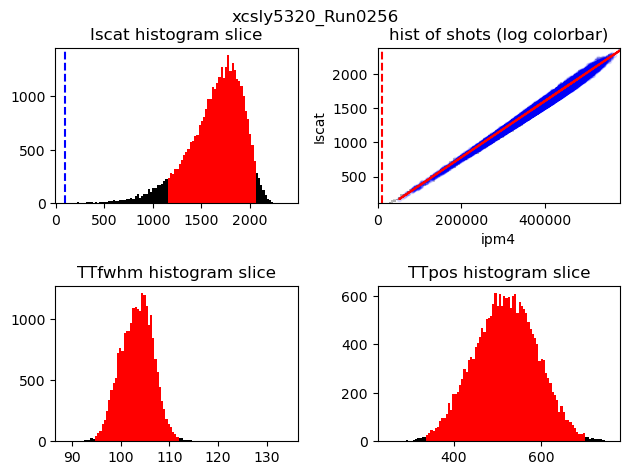

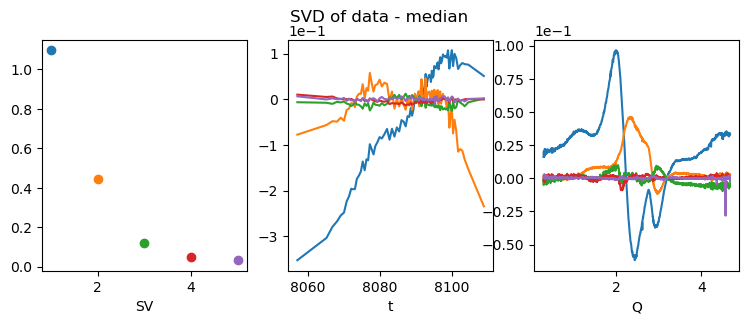

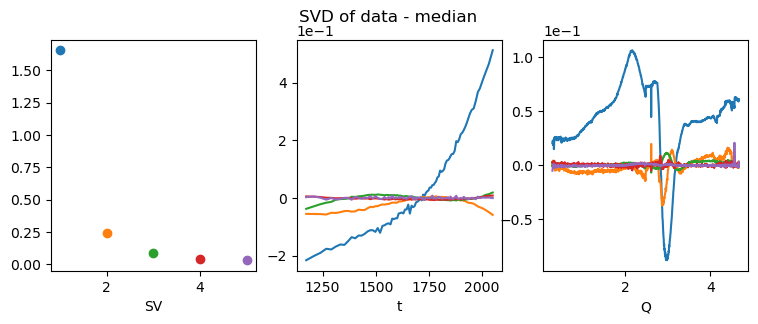

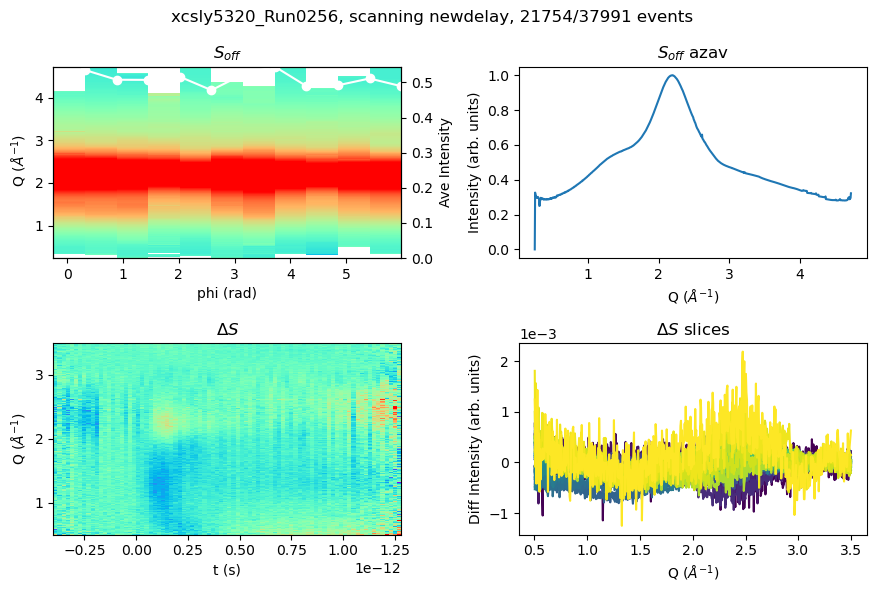

In [17]:
runs=[256]

ReduceData(smalldata_folder,exper,runs,outpath,paramDict,varDict)
    

# Stack Runs 

In [18]:
runpath=outpath+'npy/'
runs2=[255,256]

stackDict=StackProccessed(runpath,exper,runs2,method='bincount')

In [19]:
#load variables from stack

print(stackDict.keys())
diff=stackDict['aveData']
ts=stackDict['ts']
qs=stackDict['qs']
phis=stackDict['phis']


dict_keys(['aveData', 'errData', 'sumBC', 'ts', 'qs', 'phis', 'runs', 'method'])


In [22]:
#do anisotropy

S0,S0_err,S2,S2_err=S0S2(diff,phis,shift_n=0)

shift is 2 degrees
84
83

Text(0.5, 0.98, '$\\Delta$S2')

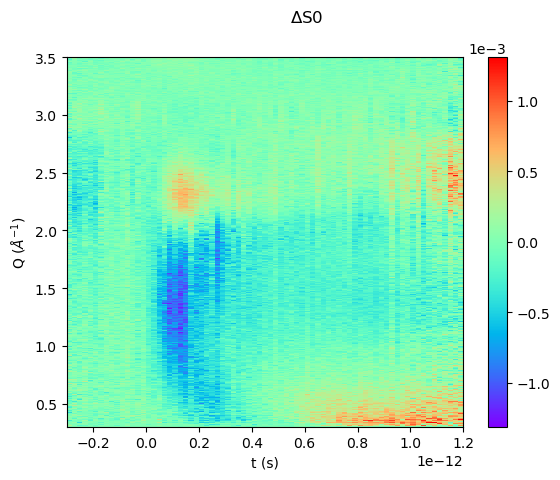

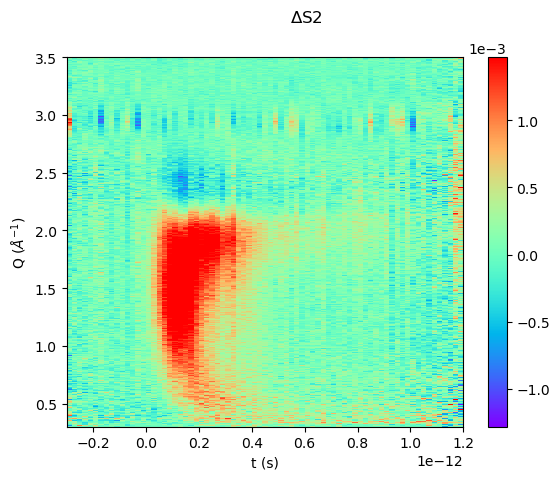

In [23]:
#plot

qrange=(0.3,3.5)
trange=(-0.3e-12,1.2e-12)

goodq=np.nonzero( (qrange[0]<qs) & (qs<qrange[1]) )
goodt=np.nonzero( (trange[0]<ts) & (ts<trange[1]) )

plot_2d(ts[goodt],qs[goodq],S0[goodt,:].squeeze()[:,goodq].squeeze())
# plt.clim(-2e-4,2e-4)
plt.suptitle('$\Delta$S0')
plot_2d(ts[goodt],qs[goodq],S2[goodt,:].squeeze()[:,goodq].squeeze())
# plt.clim(-2e-4,2e-4)
plt.suptitle('$\Delta$S2')